In [3]:
import numpy as np


#Generates N nodes and returns an array of tuples of their position.
def N_node_gen(N):
    node_list = list()
    for _ in range(N):
        node_list.append(np.array((np.random.random(), np.random.random())))
    return node_list

test_nodes = N_node_gen(5)
test_nodes

[array([0.41445593, 0.62626048]),
 array([0.8189678 , 0.48445324]),
 array([0.9100902 , 0.57530345]),
 array([0.03192033, 0.57278794]),
 array([0.80916519, 0.95000723])]

In [4]:
import numpy as np

#Returns adjacency matrix of the generated graph

def adj_mat_gen(node_list, R):
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1 - dist/R
                adj_mat[j, i] = 1 - dist/R
    return adj_mat

test_adj_mat = adj_mat_gen(test_nodes, 0.5)

test_adj_mat

array([[0.        , 0.1427039 , 0.00350624, 0.22749033, 0.        ],
       [0.1427039 , 0.        , 0.74265157, 0.        , 0.06868564],
       [0.00350624, 0.74265157, 0.        , 0.        , 0.2238846 ],
       [0.22749033, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.06868564, 0.2238846 , 0.        , 0.        ]])

In [5]:
#Produces the matrix W(i)

def W_i_gen(i, adj_mat, gamma):
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            val = adj_mat[i, j].item()
            W_i[j, j] = gamma * val
            W_i[j, i] = 1 - gamma * val
        else:
            W_i[j, j] = 1
    return W_i

test_W_1 = W_i_gen(1, test_adj_mat, 0.5)

test_W_1

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.92864805, 0.07135195, 0.        , 0.        , 0.        ],
       [0.99824688, 0.        , 0.00175312, 0.        , 0.        ],
       [0.88625483, 0.        , 0.        , 0.11374517, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [6]:
#A single step of the simulation

def update_step(x, adj_mat, gamma):
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

test_x = np.random.random(size=5)
update_step(test_x, test_adj_mat, 0.5)

array([0.42527858, 0.41792373, 0.35405713, 0.20192901, 0.42143132])

In [7]:
import numpy as np

def simulate(x_0, adj_mat, gamma, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

test_x = np.random.random(size=5)
test_simulation = simulate(test_x, test_adj_mat, 0.5, 10)
test_simulation

array([[0.22158854, 0.81216728, 0.14598732, 0.8398134 , 0.74813321],
       [0.22158854, 0.75033232, 0.68072762, 0.8398134 , 0.74813321],
       [0.67992269, 0.70657364, 0.68072762, 0.8398134 , 0.68827316],
       [0.82162661, 0.70657364, 0.68072762, 0.8398134 , 0.68827316],
       [0.71478289, 0.70657364, 0.69697635, 0.8398134 , 0.70594515],
       [0.70715939, 0.70657364, 0.70300992, 0.8398134 , 0.70655206],
       [0.70301719, 0.70433322, 0.70300992, 0.8398134 , 0.70340643],
       [0.70423932, 0.70433322, 0.70384184, 0.8398134 , 0.70430139],
       [0.70423932, 0.70424602, 0.70423862, 0.71966021, 0.70430139],
       [0.70423932, 0.70429949, 0.70429436, 0.71966021, 0.70430139],
       [0.71790616, 0.70429949, 0.70429436, 0.71966021, 0.70430139]])

In [8]:
#The following code investigates convergence in expectation to the initial value

simulate_num = 1000
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 10000
gamma = 0.5

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)
desired_x = 1/N * np.sum(x_0) * np.ones(N)

x = np.zeros(N)
for _ in range(simulate_num):
    x += simulate(x_0, adj_mat, gamma, time = 100)[-1]
x /= simulate_num

print(np.linalg.norm(x - desired_x))

0.05659452195902393


In [26]:
N = 100
R = np.sqrt(np.log(N)/N)
t = 1000
gamma = 0.5
sim_num = 1000

x_0 = np.random.random(N)
desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(t+1)])
x_array = np.zeros((t+1, N))

for _ in range(sim_num):
    x_array += simulate(x_0, adj_mat, gamma, t)

x_array /= sim_num
x_array -= desired_x

plot_vals = np.linalg.norm(x_array, axis=1)

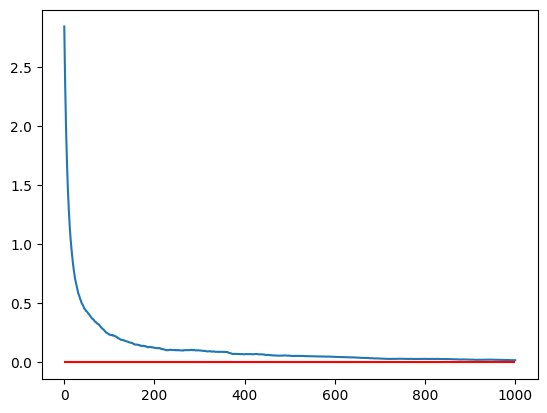

In [27]:
import matplotlib.pyplot as plt

plt.plot(t_array, plot_vals)
plt.hlines(0, 0, 1000, colors='r')